In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import phate
import scprep
import scipy


import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from sklearn.manifold import MDS


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader
from src.data.make_dataset import make_n_sphere_two
from src.data.make_dataset import make_tree
from src.data.make_dataset import make_live_seq
from src.fim_noemb import FIM
import os
from sklearn.decomposition import PCA
import math
import random

# Tree Data

In [2]:
# Data Parameters
dataset = "tree"
n_obs = 1500
n_dim = 10
batch_size = 100

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
input_dim = n_dim
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=True #Rescale of PHATE parameters

# Trainer param
max_epochs = 300
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "tree_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [3]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="tree_autoenocder_logp", name=exp_name) if wandb else False

In [4]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)


In [5]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=input_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 296


[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 16.2 K
1 | decoder | Sequential | 242   
---------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [8]:

print(model)

LitAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): Softmax(dim=1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
  )
)


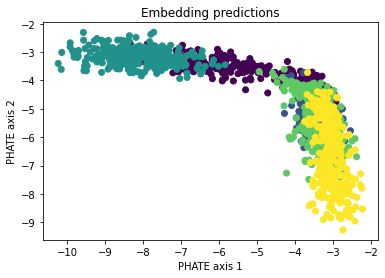

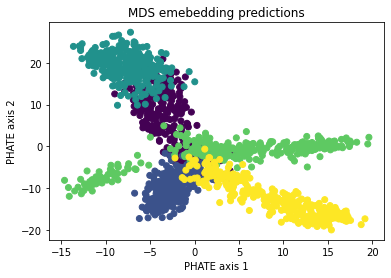

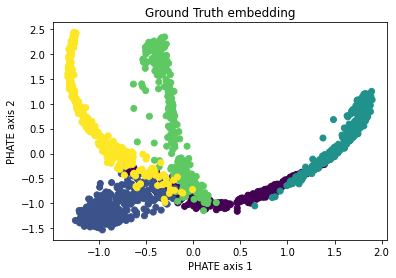

In [6]:
#Evaluate pytorch model on new data

tree_data, tree_phate, tree_clusters = make_tree(n_obs=1500,dim=10,emb_dim=2,knn=knn)
tree_data = tree_data.to('cuda')
model.cuda()
model.eval()
pred = model.encode(tree_data).detach().cpu().numpy()



mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1], c= tree_clusters)
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("MDS emebedding predictions")
plt.scatter(predemb[:, 0], predemb[:, 1], c= tree_clusters)
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("Ground Truth embedding")
plt.scatter(tree_phate[:,0],tree_phate[:,1], c=tree_clusters )
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")


np.save("saved_data/5_300_tree_1_1_1500_pred.npy",pred)
np.save("saved_data/5_300_tree_1_1_1500_pred_MDS.npy",predemb)


In [7]:
#Compute FIM 
n_obs = tree_data.shape[0]
model.cuda()
fcn = model.encode
fisher = FIM(tree_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
#volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model.eval()
vout = model.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())



In [84]:
#Debugging/Nonsense Code
np.random.randint(0,360,1)[0]
print(e[0:5,:])
print(J.shape)
print(e.shape)
rint = np.random.randint(0,e.shape[0],size=10)
print(rint[0])
print(tree_phate.shape)
print(predemb.shape)
print(pred.shape)

"""
#Getting low dimensional eigenvectors
ldimeivec = np.zeros((J.shape[0],J.shape[1]))
for i in range(J.shape[0]):
    vtest = v[i,-1,:] #Get top eigenvector for each sample
    Jtest = J[i,:,:] #Get Jacobian for each sample
    ldimeivec[i,:] = np.expand_dims(Jtest @ vtest,axis=0) #Project down to 2 dimensions
    
print(predemb.shape)
print(ldimeivec.shape)
print(v.shape)
print(v[tind,0,:].shape)
print(predemb[tind,1].shape)

"""

"""
plt.figure()
plt.scatter(predemb[tind,0],predemb[tind,1],c=tind)
plt.quiver(predemb[tind,0],predemb[tind,1],u,vee)
plt.quiver(predemb[tind,0],predemb[tind,1],ut,veet)


        
plt.figure()
#plt.scatter(ldimeivec[:,0],ldimeivec[:,1],marker = ",") #plotting eigenvec [nsamp x dims]
plt.scatter(predemb[tind,0], predemb[tind,1], c= ntrace)
plt.colorbar()
sys.exit()

"""

#plt.subplot(231)
#plt.title("Volume",fontsize=14)
#plt.plot(nvolume)
#plt.xlabel("Data points",fontsize=14)
#plt.ylabel("Normalized volume",fontsize=14)

[[0.00709446 0.00395019 0.00242066 0.00210971 0.00120766 0.0011003
  0.00075209 0.00018309 0.00032624 0.00048803]
 [0.0108151  0.00300608 0.00179511 0.00109944 0.00084799 0.00013168
  0.00023918 0.00037627 0.00045695 0.00050006]
 [0.00583967 0.00413583 0.00290423 0.00125788 0.00086579 0.00014194
  0.00016819 0.00022782 0.00047213 0.00054795]
 [0.01096814 0.00279626 0.00158235 0.00137824 0.00083942 0.00066346
  0.00047603 0.00020142 0.00035805 0.00026786]
 [0.00936103 0.00332237 0.00199253 0.00126849 0.00115138 0.00025829
  0.00070833 0.00060919 0.00039396 0.0004818 ]]
(1500, 50, 10)
(1500, 10)
1421
(1500, 2)
(1500, 2)
(1500, 50)


'\nplt.figure()\nplt.scatter(predemb[tind,0],predemb[tind,1],c=tind)\nplt.quiver(predemb[tind,0],predemb[tind,1],u,vee)\nplt.quiver(predemb[tind,0],predemb[tind,1],ut,veet)\n\n\n        \nplt.figure()\n#plt.scatter(ldimeivec[:,0],ldimeivec[:,1],marker = ",") #plotting eigenvec [nsamp x dims]\nplt.scatter(predemb[tind,0], predemb[tind,1], c= ntrace)\nplt.colorbar()\nsys.exit()\n\n'

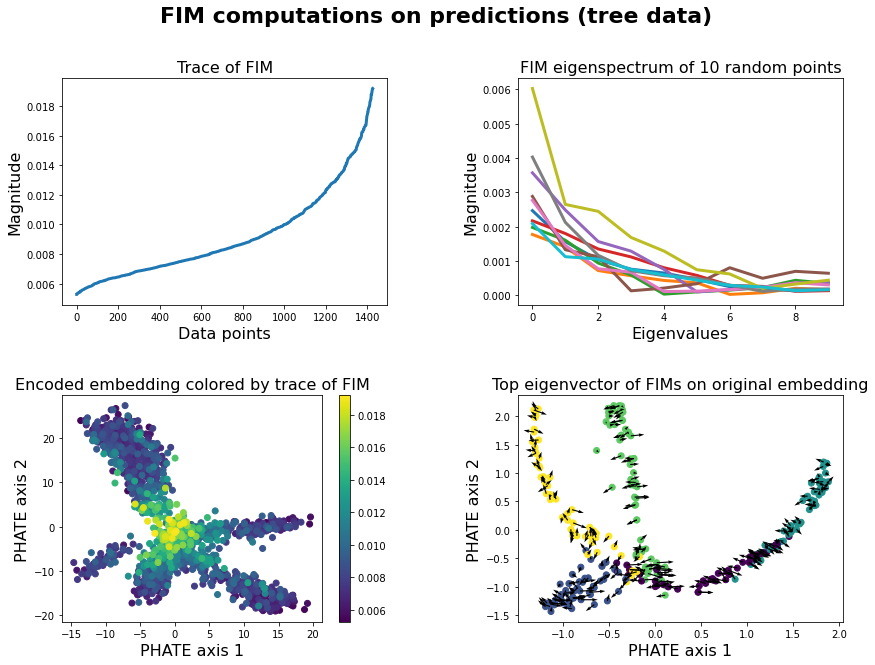

In [8]:

#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
#vind = discard_out(volume,n_obs,per)
#nvolume = volume[vind]/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (tree data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
plt.subplot(221)
plt.title("Trace of FIM",fontsize=16)
plt.plot(ntrace,linewidth=3)
plt.xlabel("Data points",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)


#Eigenspectrum
rint = np.random.randint(0,np.max(tind),size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)


#Trace
plt.subplot(223)
plt.title("Encoded embedding colored by trace of FIM",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()




#Visualization of eignevectors
reint = np.random.randint(0,tree_phate.shape[0],size=300) #Random 
plt.subplot(224)
plt.title("Top eigenvector of FIMs on original embedding",fontsize=16)
plt.scatter(tree_phate[reint,0],tree_phate[reint,1],c=tree_clusters[reint])
plt.quiver(tree_phate[reint,0],tree_phate[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.savefig("Figures/5_300_tree_FIMcomps_1_1.png")

In [ ]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIM's for 10 random samples (tree data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()
    
plt.savefig('random_FIMs.png')

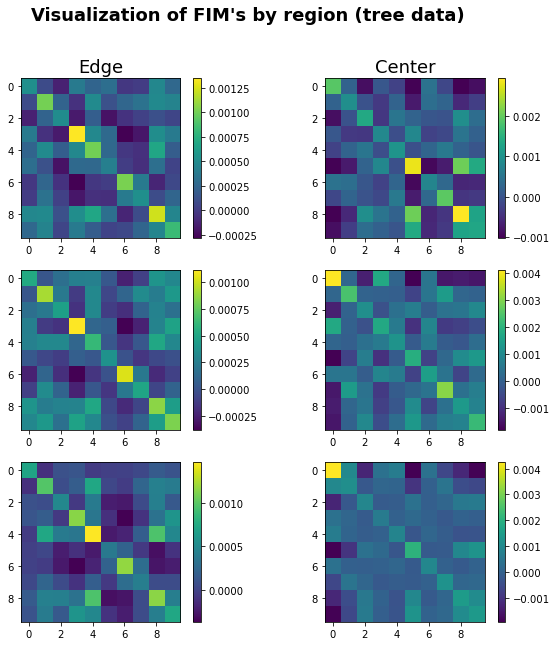

In [9]:


#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm(predemb,ord=2,axis=1))

plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (tree data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5:
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0:
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig("Figures/5_300_tree_regional_FIMs_1_1.png")

#plt.figure()
#plt.scatter(predemb[:,0],predemb[:,1])
#plt.scatter(predemb[distind[1400:],0],predemb[distind[1400:],1],c='red')

Text(0, 0.5, 'Magnitude')

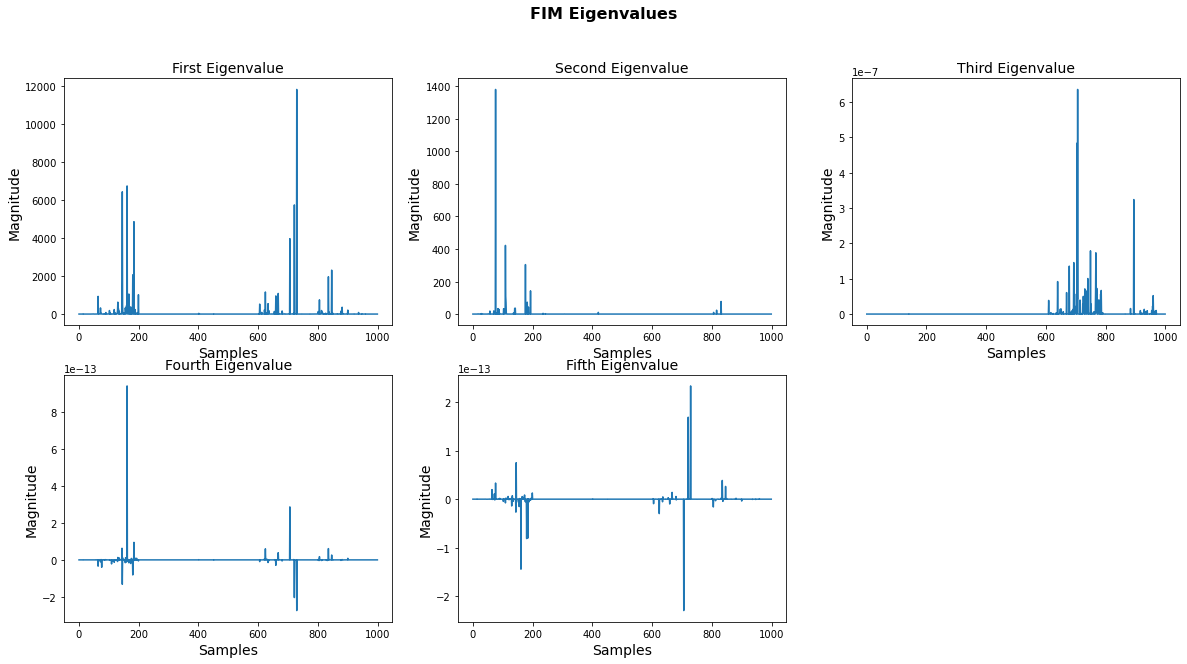

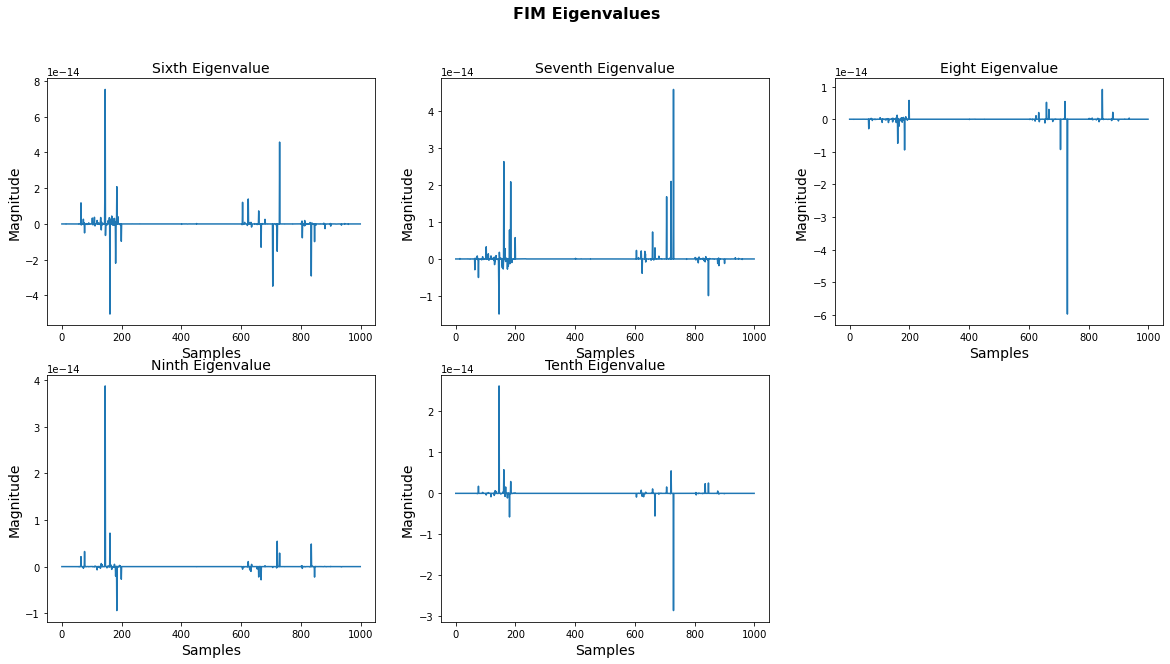

In [49]:

#More eigenvector/eigenvalue analysis of FIM

"""
ldimeivec = np.zeros((J.shape[0],J.shape[1]))
for i in range(J.shape[0]):
    vtest = v[i,-1,:]
    Jtest = J[i,:,:]
    ldimeivec[i,:] = np.expand_dims(Jtest @ vtest,axis=0)


plt.figure()
#plt.scatter(ldimeivec[:,0],ldimeivec[:,1],marker = ",") #plotting eigenvec [nsamp x dims]
plt.scatter(pred[tind,0], pred[tind,1], c= ntrace)
plt.colorbar()
sys.exit()

"""

plt.figure(figsize=(20,10))
plt.suptitle("FIM Eigenvalues",fontsize=16,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.2)

plt.subplot(231)
plt.title("First Eigenvalue",fontsize=14)
plt.plot(e[:,0])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)

plt.subplot(232)
plt.title("Second Eigenvalue",fontsize=14)
plt.plot(e[:,1])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)

plt.subplot(233)
plt.title("Third Eigenvalue",fontsize=14)
plt.plot(e[:,2])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)

plt.subplot(234)
plt.title("Fourth Eigenvalue",fontsize=14)
plt.plot(e[:,3])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)

plt.subplot(235)
plt.title("Fifth Eigenvalue",fontsize=14)
plt.plot(e[:,4])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)

plt.figure(figsize=(20,10))
plt.suptitle("FIM Eigenvalues",fontsize=16,fontweight='bold')
plt.subplot(231)
plt.title("Sixth Eigenvalue",fontsize=14)
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)
plt.plot(e[:,5])
plt.subplot(232)
plt.title("Seventh Eigenvalue",fontsize=14)
plt.plot(e[:,6])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)
plt.subplot(233)
plt.title("Eight Eigenvalue",fontsize=14)
plt.plot(e[:,7])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)
plt.subplot(234)
plt.title("Ninth Eigenvalue",fontsize=14)
plt.plot(e[:,8])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)
plt.subplot(235)
plt.title("Tenth Eigenvalue",fontsize=14)
plt.plot(e[:,9])
plt.xlabel("Samples",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)


# Sphere Data

In [12]:
# Data Parameters
dataset = "sphere"
n_obs = 1500
n_dim = 10
batch_size = 100

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
input_dim = n_dim
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=True

# Trainer param
max_epochs = 300
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "sphere_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [13]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="sphere_autoenocder_logp", name=exp_name) if wandb else False

In [14]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

In [15]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model_sphere = LitAutoencoder(
    input_dim=input_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_sphere, train_dataloaders=train_loader)

Global seed set to 58


[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 16.2 K
1 | decoder | Sequential | 242   
---------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


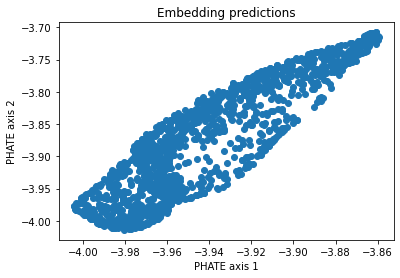

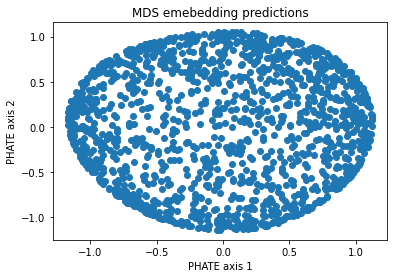

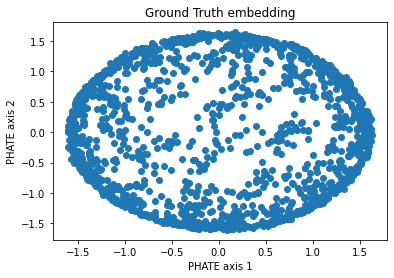

In [16]:
#Evaluate pytorch model on new data

sphere_data, sphere_phate = make_n_sphere_two(n_obs=n_obs,dim=10,emb_dim=2,knn=knn)
sphere_data = sphere_data.to('cuda')
model_sphere.cuda()
model_sphere.eval()
pred = model_sphere.encode(sphere_data).detach().cpu().numpy()

mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("MDS emebedding predictions")
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("Ground Truth embedding")
plt.scatter(sphere_phate[:,0],sphere_phate[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")


np.save("saved_data/1500_sphere_1_1_pred.npy",pred)
np.save("saved_data/1500_sphere_1_1_pred_MDS.npy",predemb)


In [17]:

#Compute FIM 
n_obs = sphere_data.shape[0]
model.cuda()
fcn = model.encode
fisher = FIM(tree_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
#volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model.eval()
vout = model.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())




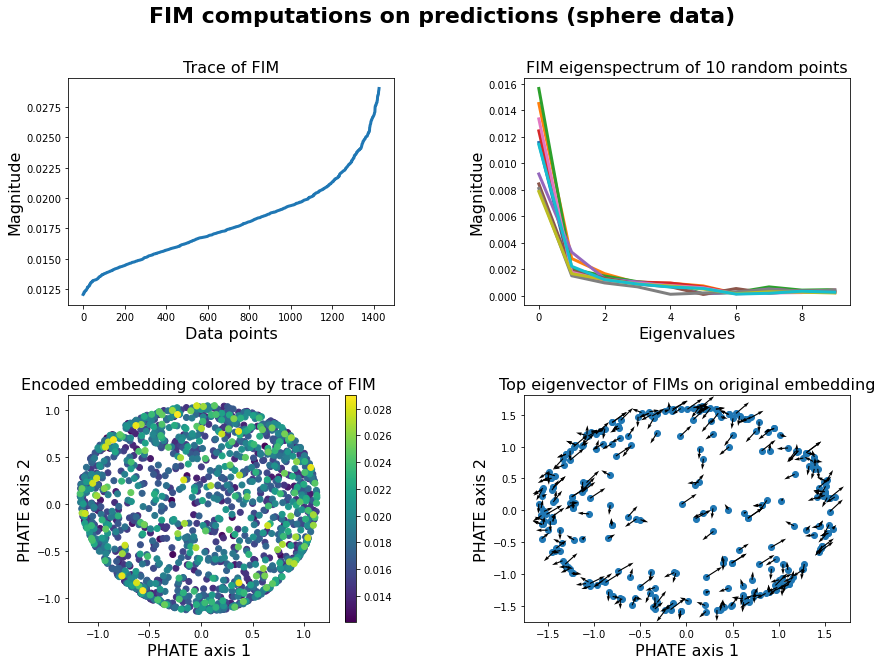

In [18]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
#vind = discard_out(volume,n_obs,per)
#nvolume = volume[vind]/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (sphere data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
plt.subplot(221)
plt.title("Trace of FIM",fontsize=16)
plt.plot(ntrace,linewidth=3)
plt.xlabel("Data points",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)


#Eigenspectrum
rint = np.random.randint(0,np.max(tind),size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)


#Trace
plt.subplot(223)
plt.title("Encoded embedding colored by trace of FIM",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
plt.colorbar()




#Visualization of eignevectors
reint = np.random.randint(0,tree_phate.shape[0],size=300) #Random 
plt.subplot(224)
plt.title("Top eigenvector of FIMs on original embedding",fontsize=16)
plt.scatter(sphere_phate[reint,0],sphere_phate[reint,1])
plt.quiver(sphere_phate[reint,0],sphere_phate[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.savefig("Figures/1500_sphere_FIMcomps_1_1.png")

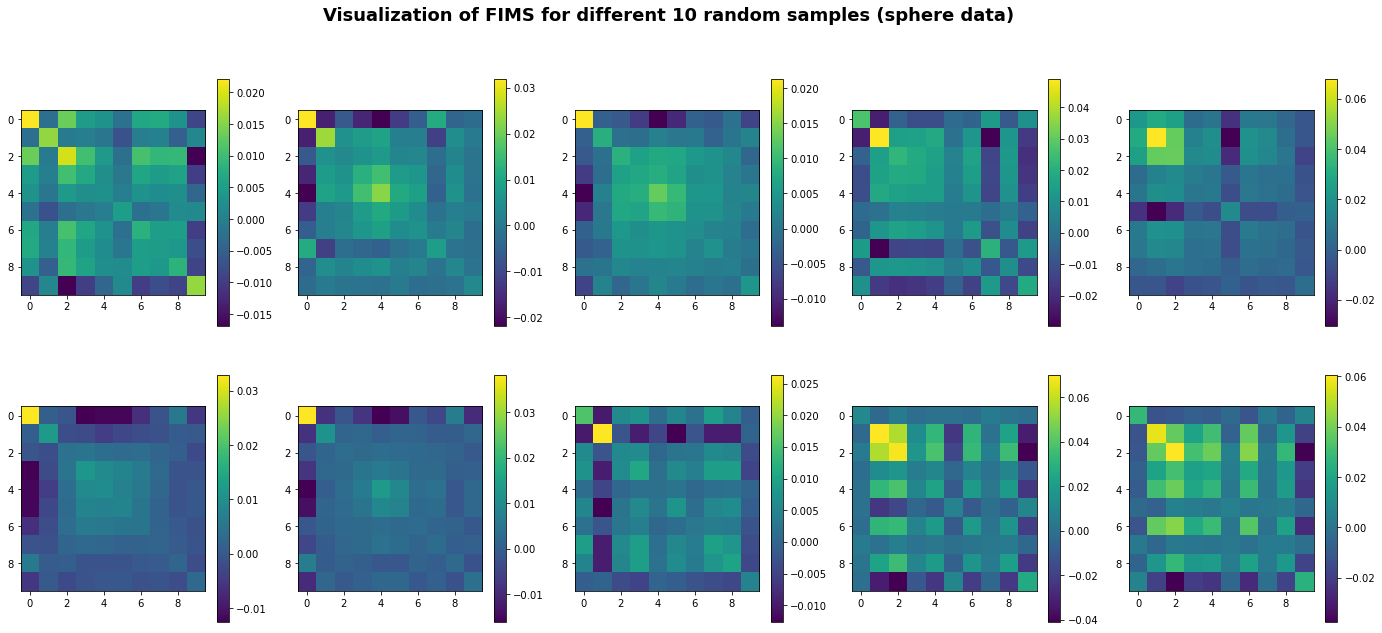

In [104]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIMS for different 10 random samples (sphere data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()

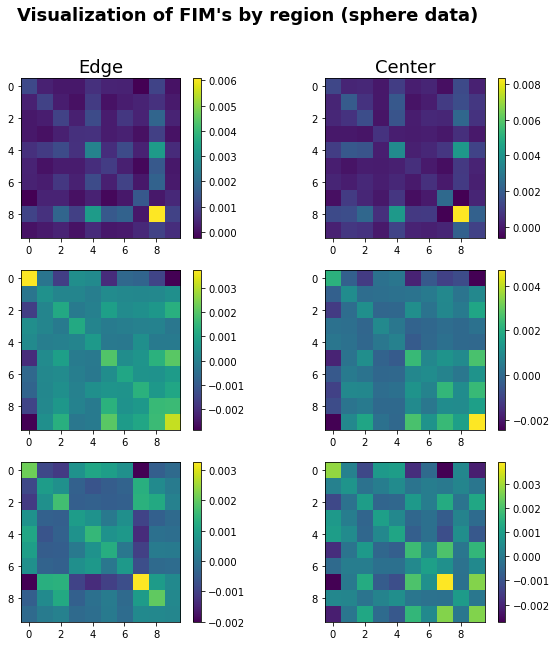

In [19]:
#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm(predemb,ord=2,axis=1))
plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (sphere data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5:
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0:
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig('Figures/1500_sphere_regional_FIMs_1_1.png')

# Single Cell Data

In [11]:
# Data Parameters
dataset = "live_seq"
n_obs = 1500
n_dim = 10
batch_size = 100

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
input_dim = 16689
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=True

# Trainer param
max_epochs = 300
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "single_cell_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [5]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="single_cell_autoenocder_logp", name=exp_name) if wandb else False

In [7]:
PATH = os.getcwd()
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

In [ ]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

# Defining the pytorch lightning model.
model_singcell = LitAutoencoder(
    input_dim=input_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_singcell, train_dataloaders=train_loader)

Global seed set to 630


[Linear(in_features=16689, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 M 
1 | decoder | Sequential | 242   
---------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.738     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]